# Tutorial 18: IVPs

## PHYS 2600

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## T16.1 - Numerical instability

Let's start by solving for the velocity of an object in freefall. To keep things simple, we're going to assume that the velocity only has a vertical component $u(t)$ and we'll choose a coordinate system where $u(t)>0$ when the object is moving towards the ground. There are two forces we need to account for

<div style="display:flex; align-items:center; gap:16px;">
  <a href="https://commons.wikimedia.org/wiki/File:Terminal_Velocity.png" target="_blank">
    <img src="https://raw.githubusercontent.com/wlough/CU-Phys2600-Fall2025/main/lectures/img/Terminal_Velocity.png" width="100">
  </a>

  <div style="margin-left:2rem;"> 
  $$
  F_{\text{d}} = -\gamma u
  $$
  $$
  F_{\text{g}} = mg
  $$
  </div>
</div>

where $m$ is the object's mass and $\gamma$ is a drag coefficient.
Since acceleration is the derivative of velocity, Newton's second law tells us 
$$
m u'(t) = mg -\gamma u(t).
$$
If we write $u_{\infty} = \frac{mg}{\gamma}$ for the terminal velocity and define a time constant $\tau = \frac{m}{\gamma}$, this is equivalent to to the equation
$$
u'(t) = -\frac{1}{\tau} \left(u(t)-u_{\infty}\right)
$$
which has the analytic solution
$$
u(t) = u_0e^{-t/\tau} + u_{\infty}\left(1-e^{-t/\tau}\right)
$$

__Run the cell below__ to plot the analytic solution over the range $0 \leq t \leq 1$.

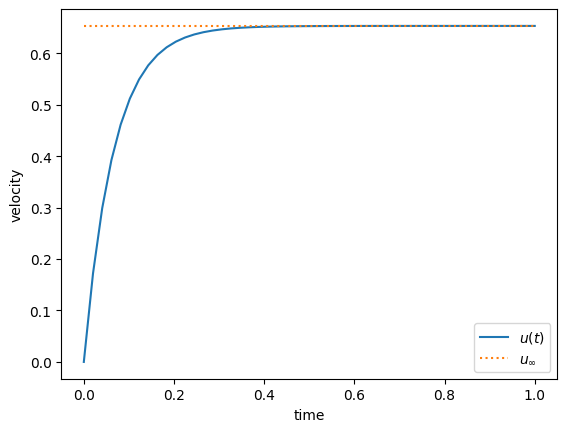

In [3]:
g, m, gamma = 9.8, 0.1, 1.5
u_inf = m * g / gamma
tau = m / gamma
u0 = 0.0

def get_exact_fun(u0, t0=0.0):
    return lambda t: u0 * np.exp(-(t-t0) / tau) + u_inf * (1 - np.exp(-(t-t0) / tau))

u_exact_fun = get_exact_fun(u0)
t_exact = np.linspace(0, 1.0, 50)
u_exact = u_exact_fun(t_exact)

plt.plot(t_exact, u_exact, label="$u(t)$")
plt.plot([t_exact[0], t_exact[-1]], [u_inf, u_inf], label=r"$u_{\infty}$", linestyle=":")
plt.xlabel("time")
plt.ylabel("velocity")
plt.legend()
plt.show()

We're going to find an approximate solution to the freefall equation using the backward Euler method. To set up a backward Euler solver for an IVP

$$
u'(t) = F(u(t), t), \quad u(0)= c
$$

we do the following:

__(1)__ Choose a discrete set of $t$-values.
$$t_k = t_0 + k\Delta t \quad \text{for} \quad k=0,1,\dots, N-1$$
__(2)__ Replace the derivative on the with a backward difference evaluated at $t=t_{i+1}$.
$$u'(t_{i+1})\approx (u_{i+1} - u_{i})/\Delta t$$
__(3)__ Evaluate the right hand side at $t=t_{i+1}$.
$$
\left.F(u(t), t)\right|_{t=t_{i+1}}=F(u_{i+1}, t_{i+1})
$$
__(4)__ Do a little bit of algebra to get our implicit equation
$$
 u_{i+1} - u_i - \Delta t F(u_{i+1}, t_{i+1}) = 0
$$
__(5)__ Start with the initial condition $u_0=c$ and solve the implicit equation at each timestep to compute subsequent values of $u$.
$$
\begin{align}
u_0 &= c\\
\text{solve}\quad u_{1} - u_{0} - &\Delta t F(u_{1}, t_{1}) = 0\quad \text{for}\quad u_{1}\\
\text{solve}\quad u_{2} - u_{1} - &\Delta t F(u_{2}, t_{2}) = 0\quad \text{for}\quad u_{2}\\
&\vdots \\
\text{solve}\quad u_{i+1} - u_{i} - &\Delta t F(u_{i+1}, t_{i+1}) = 0\quad \text{for}\quad u_{i+1}\\
\end{align}
$$

Generally you need to use a root finding algorithm like Newton's method to solve for $u_{i+1}$ at each timestep. In some problems (like the freefall problem!), $F$ is simple enough that we can actually solve the implicit equation to find an explicit formula for $u_{i+1}$.

### Part A: Solving the implicit equation by hand
In the text cell below, write the __implicit__ equation that needs to be solved at each timestep to find $u_{i+1}$.

YOUR SOLUTION HERE

<!--BEGIN SOLUTION  -->
Using $F(u_{i+1}, t_{i+1}) = -\left(u_{i+1}-u_{\infty}\right)/\tau$, we have

$$
u_{i+1} - u_{i} + \Delta t \left(u_{i+1}-u_{\infty}\right)/\tau = 0
$$

<!--END SOLUTION  -->

We'll come back to the implicit equation in part B, but we're going to start by solving the implicit equation by hand. Solve the implicit equation to get an __explicit__ formula for $u_{i+1}$ and write your answer in the text cell below.

YOUR SOLUTION HERE

<!--BEGIN SOLUTION  -->
Solving our implicit equation for $u_{i+1}$ gives

$$
u_{i+1} = \frac{u_i+\Delta t u_{\infty}/\tau}{1+\Delta t/\tau}
$$

<!--END SOLUTION  -->

Fill out the function `backward_euler_step_explicit(ui, dt)` which should use your __explicit__ formula to calculate and return $u_{i+1}$ given the $u_i$ and the step size $\Delta t$.

In [4]:

def backward_euler_step_explicit(ui, dt):
    ### BEGIN SOLUTION
    return (ui+dt*u_inf/tau)/(1+dt/tau)
    ### END SOLUTION


In [5]:
import numpy.testing as npt

npt.assert_allclose(backward_euler_step_explicit(0, 0.1), 0.392)
npt.assert_allclose(backward_euler_step_explicit(0, 0.01), 0.085217, atol=1e-4)
npt.assert_allclose(backward_euler_step_explicit(0.08521739, 0.01), 0.159319, atol=1e-4)

Now implement a function `backward_euler_solve_explicit(t, u0)` which uses your `backward_euler_step_explicit` to compute the numerical solution from an array of time samples `t=[t_0, t_1,...]` and an initial velocity `u0`.

In [6]:
### BEGIN SOLUTION
def backward_euler_solve_explicit(t, u0):
    u = np.zeros_like(t)
    u[0] = u0
    dt = t[1] - t[0]
    for i in range(0, len(t) - 1):
        u[i + 1] = backward_euler_step_explicit(u[i], dt)
    return u
### END SOLUTION

Now let's compare our numerical solution to the analytic solution. Use your `backward_euler_solve_explicit` function to find the solution solution to the IVP over the time interval $0 \leq t \leq 1$ with initial condition $u(0)=0$ and add it to the plot below.

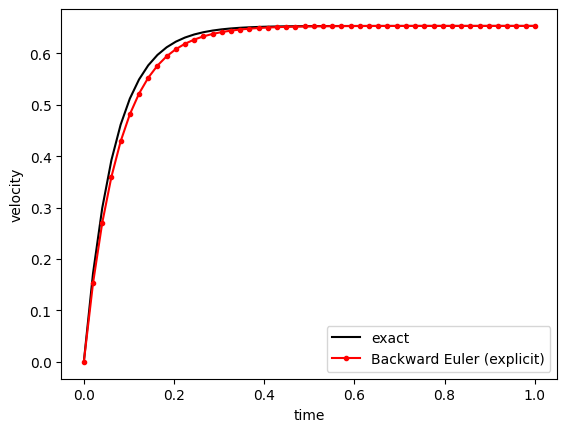

In [8]:

plt.plot(t_exact, u_exact, color="k", label="exact")
plt.xlabel("time")
plt.ylabel("velocity")


### BEGIN SOLUTION
t = np.linspace(0, 1.0, 50)
u_explicit = backward_euler_solve_explicit(t, 0.0)
plt.plot(t, u_explicit, color="r", marker=".", label="Backward Euler (explicit)")
### END SOLUTION

plt.legend()

### Part B: Solving the implicit equation numerically

In the cell below, __fill out the function `backward_euler_step(ui, dt)` below__, which should __calculate and return $u_{i+1}$__ given the two quantities  $u_i$ and the step size $\Delta t$. Hint: you can use the result of a forward Euler step as your guess to initialize Newton's method.

In [ ]:
from scipy.optimize import newton
def backward_euler_step(ui, dt):
    ### BEGIN SOLUTION
    def implicit_eq(uip1):
        return uip1 - ui + dt*(uip1 - u_inf)/tau

    uip1_guess = ui - dt*(ui - u_inf)/tau
    return newton(implicit_eq, uip1_guess)
    ### END SOLUTION

def backward_euler_solve(t, u0):
    u = np.zeros_like(t)
    u[0] = u0
    dt = t[1] - t[0]
    for i in range(0, len(t) - 1):
        u[i + 1] = backward_euler_step(u[i], dt)
    return u




u_exact_fun = get_exact_fun(u0)
t = np.linspace(0, 1.0, 500)
u_exact = u_exact_fun(t)
u_explicit = backward_euler_solve_explicit(t, u0)
u_implicit = backward_euler_solve(t, u0)


plt.plot(t, u_exact, color="k", label="exact")
plt.plot(t, u_explicit, color="r", marker="o", label="Backward Euler (explicit)")
plt.plot(t, u_implicit, color="b", marker=".", label="Backward Euler (implicit)")
plt.xlabel("time")
plt.ylabel("velocity")
plt.legend()

In [ ]:
def forward_euler_solve(t, u0):
    u = np.zeros_like(t)
    u[0] = u0
    dt = t[1] - t[0]
    for i in range(0, len(t) - 1):
        u[i + 1] = u[i] - dt*(u[i] - u_inf)/tau
    return u

def fb_compare_plot(u0, t_final, Nt_list):

    u_exact_fun = get_exact_fun(u0)

    num_rows = len(Nt_list)
    fig, axes = plt.subplots(1, num_rows, figsize=(8, 3.25))

    for ax, Nt in zip(axes, Nt_list):
        t = np.linspace(0, t_final, Nt)
        u_exact = u_exact_fun(t)
        u_fe = forward_euler_solve(t, u0)
        u_be = backward_euler_solve(t, u0)

        dt = t[1] - t[0]
        ax.set_title(r"$\Delta t =" + f"{dt: 0.2f}" + r"$")
        ax.plot(t, u_be, linestyle="--", label="Backward Euler")
        ax.plot(t, u_exact, linestyle="-", label="Exact")
        ax.plot(t, u_fe, linestyle=":", label="Forward Euler")
        ax.grid(True)
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

Nt_list = [40, 15, 10]
fb_compare_plot(0, 1, Nt_list)

## T16.2 - BVPs

### Part A: build D1, and D2

In [ ]:
from scipy.sparse import diags

Nx = 100
x0, xNm1 = 0.0, 2*np.pi
dx = (xNm1-x0)/(Nx-1)



D1_central = diags(diagonals=[-0.5*np.ones(Nx-1), np.zeros(Nx), 0.5*np.ones(Nx-1)],
    offsets=[-1, 0, 1],
    shape=(Nx, Nx),
    format="csr",)/dx

D1_forward = diags(diagonals=[-np.ones(Nx), np.ones(Nx-1)],
    offsets=[ 0,1],
    shape=(Nx, Nx),
    format="csr",)/dx

D1_backward = diags(diagonals=[-np.ones(Nx-1), np.ones(Nx)],
    offsets=[ -1,0],
    shape=(Nx, Nx),
    format="csr",)/dx

D2_central = diags(diagonals=[np.ones(Nx-1), -2*np.ones(Nx), np.ones(Nx-1)],
    offsets=[-1, 0, 1],
    shape=(Nx, Nx),
    format="csr",)/dx**2

D1_central.toarray()[0, :3]
# np.linalg.eig


hbar2_over_2me = 3.81e-2

L = 

$$
\frac{d^2 \psi}{dx^2} = \frac{2m}{\hbar^2} [V(x) - E] \psi(x).
$$

$$
\frac{\hbar^2}{2m}\frac{d^2 \psi}{dx^2} -  V(x)\psi(x) = -E \psi(x).
$$

$$
\left[-\frac{\hbar^2}{2m}\frac{d^2 }{dx^2} +  V(x)\right]\psi(x) = E \psi(x).
$$

$$
\mathscr{L} = -\frac{\hbar^2}{2m}\frac{d^2 }{dx^2} +  V(x)
$$


$$
\mathbf{\Psi} 
= 
\left[
\begin{matrix}
\psi_0\\
\psi_{2}\\
\vdots\\
\psi_{N-1}
\end{matrix}
\right]
$$


$$
\mathbf{D}^{(1)}
=
\frac{1}{2\Delta x}
\begin{bmatrix}
-3 & 4 & -1 & 0 & \cdots & 0 & 0 \\
-1 & 0 & 1 & 0 & \cdots & 0 & 0 \\
0 & -1 & 0 & 1 & \cdots & 0 & 0 \\
0 & 0 & -1 & 0 & \ddots & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \ddots & 1 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 & 1 \\
0 & 0 & 0 & 0 & 1 & -4 & 3
\end{bmatrix}
$$

$$
\mathbf{D}^{(2)}
=
\frac{1}{\Delta x^2}
\begin{bmatrix}
-2 & 1 & 0 & 0 & \cdots & 0 & 0 \\
1 & -2 & 1 & 0 & \cdots & 0 & 0 \\
0 & 1 & -2 & 1 & \cdots & 0 & 0 \\
0 & 0 & 1 & -2 & \ddots & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \ddots & 1 & 0 \\
0 & 0 & 0 & 0 & 1 & -2 & 1 \\
0 & 0 & 0 & 0 & 0 & 1 & -2
\end{bmatrix}
$$

$$
\mathbf{V} 
= 
\begin{bmatrix}
V_0 & 0   & \cdots & 0   & 0 \\
0   & V_1 & \cdots & 0   & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0   & 0   & \cdots & V_{N-2} & 0 \\
0   & 0   & \cdots & 0   & V_{N-1}
\end{bmatrix}
$$


$$
\tilde{\mathbf{L}} = -\frac{\hbar^2}{2m}\mathbf{D}^{(2)} +  \mathbf{V} 
$$

$\mathbf{L}_{ij} = \tilde{\mathbf{L}}_{ij}$ for $1\leq i\leq N-2$ (equivalent to $i\neq 0, N-1$), but we need to change the first and last rows to account for the boundary conditions 

$$
\begin{bmatrix}
\mathbf{L}_{00} & \mathbf{L}_{01} & \dots & \mathbf{L}_{0,N-1}\\
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 &\dots & 0\\
\end{bmatrix}
$$

$$
\begin{bmatrix}
\mathbf{L}_{N-1,0} & \dots & \mathbf{L}_{N-1,N-2} & \mathbf{L}_{N-1,N-1}\\
\end{bmatrix}
=
\begin{bmatrix}
0 & \dots & 0 & 1\\
\end{bmatrix}
$$